In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from scipy.special import legendre
import math
from itertools import product
from scipy.special import gamma
import sys
import pandas as pd
import seaborn as sns
sns.set()
from PC_VRVM import *
from AFVB_PCE import *

In [2]:
### Making a Basis function
### This will be inputed into the ChaosModel function

def basis(Z):
    """
    input:
    
    return:
    
    """
    d = 3
    max_deg = 8
    N = Z.shape[0] # Number of samples
    n = int(math.factorial(d + max_deg)/(math.factorial(d)*math.factorial(max_deg)))
    Phi = np.zeros((N, n))
    
    #########################################################
    #### Compute multivariate orthonormal polynomial Phi ####
    #########################################################
    def multivariate_pce_index(d, max_deg):
        """
        Generate all the d-dimensional polynomial indices with the 
        constraint that the sum of the indexes is <= max_deg
    
        input:
        d: int, number of random variables
        max_deg: int, the max degree allowed
    
        return: 
        2d array with shape[1] equal to d, the multivariate indices
        """
        maxRange = max_deg*np.ones(d, dtype = 'int')
        index = np.array([i for i in product(*(range(i + 1) for i in maxRange)) if sum(i) <= max_deg])
        return index
    
    index = multivariate_pce_index(d, max_deg)

    for i in range(n):
        Phi[:,i] =  math.sqrt(2*index[i][0]+1)*math.sqrt(2*index[i][1]+1)*math.sqrt(2*index[i][2]+1) \
                   *legendre(index[i][0])(Z[:,0]) \
                   *legendre(index[i][1])(Z[:,1]) \
                   *legendre(index[i][2])(Z[:,2])
    
    return Phi

## AFVB-PCE (Bhattacharyya) - Ishigami Function 

In [3]:
################
#### Inputs ####
################
N = 35 # N --> number of samples
d = 3  # d --> number of random variables
p = 8  # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion
# A_0 and B_0 --> the parameters of the Gamma distribution in the joint Gaussian-Gamma 
# distribution used to express the prior
A_0 = 0.1 
B_0 = 0.0001 
# C_0 and D_0 --> the paramters of the Gamma distribution in the distribution of the hyper-prior
C_0 = 0.1
D_0 = 0.0001 
T_ell = 0.001 # T_ell --> threshold value for the VLB (for the error e_ell) in percent
e = 1000 # e --> ddjustable parameter for the threshold value 

In [4]:
np.random.seed(123)

data={'Xi':np.random.uniform(-1,1,size=(N,d))}
data['Y'] = np.sin(np.pi*data['Xi'][:,0]) + 7*(np.sin(np.pi*data['Xi'][:,1]))**2 + 0.1*(np.pi*data['Xi'][:,2])**4*np.sin(np.pi*data['Xi'][:,0])

params = {'A_0' : A_0, 'B_0': B_0, 'C_0': C_0, 'D_0': D_0}
mod = AFVB_PCE(params, p, data, basis)
Phi_hat, a_hat, Phi_full, a_full, active_cols = mod.algorithm(T_ell, e)


1 (35, 165) -64.0223738192413
2 (35, 160) -63.84619895506427
3 (35, 157) -70.47627244199782
4 (35, 141) -105.7200359597332
5 (35, 112) -176.8588494469659
6 (35, 86) -143.54946946266114
7 (35, 59) -108.99590397188422
8 (35, 47) -93.6533379897541
9 (35, 40) -84.71341282542741
10 (35, 32) -74.50964557413562
11 (35, 27) -68.13965797276782
12 (35, 24) -64.3233415535948
13 (35, 22) -61.78296666879295
14 (35, 21) -60.51399092885279
15 (35, 19) -57.980182389279456
16 (35, 17) -55.4539769119672
17 (35, 16) -54.19091244618532
18 (35, 15) -52.93001670097477
19 (35, 14) -51.672743325037324
20 (35, 13) -50.419404581499045
21 (35, 12) -51.65156214106576
22 (35, 11) -63.74309823364546
23 (35, 10) -67.65043691817802
24 (35, 9) -70.8868126111229
25 (35, 8) -72.09373320929402
26 (35, 7) -73.69396799311679
27 (35, 6) -72.72427845260793
28 (35, 5) -74.59872925840416
29 (35, 4) -89.2918437580275
30 (35, 3) -94.57927420089712
31 (35, 2) -104.51351335006652


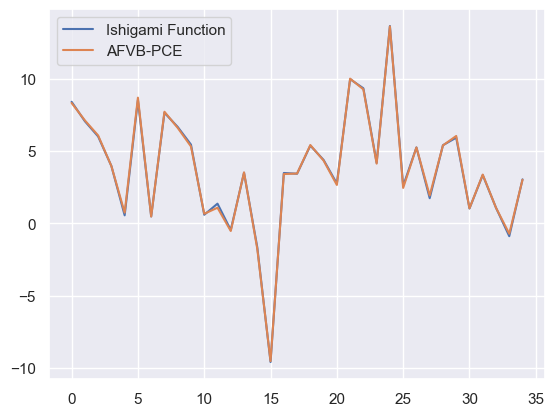

In [5]:
plt.plot(data['Y'], label = "Ishigami Function")
plt.plot(Phi_hat@a_hat, label = "AFVB-PCE")
plt.legend();

In [6]:
active_cols

array([  0,  17,  30,  39,  44,  45,  46,  49,  74, 109, 110, 111, 113,
       145])

In [7]:
active_cols.shape

(14,)

In [ ]:
#add coefficients to mod using mod._coeffs = ...

### Using Test Data

In [13]:
from sklearn.metrics import mean_squared_error

In [20]:
Test_data={'Xi':np.random.uniform(-1, 1, size=(100,d))}

z_1 = Test_data['Xi'][:,0]
z_2 = Test_data['Xi'][:,1]
z_3 = Test_data['Xi'][:,2]

Test_data['Y'] = np.c_[np.sin(np.pi*z_1) + 7*(np.sin(np.pi*z_2))**2 + 0.1*(np.pi*z_3)**4*np.sin(np.pi*z_1)]

In [21]:
Phi_test_full = basis(Test_data['Xi'])
Phi_test = basis(Test_data['Xi'])[:,active_cols]

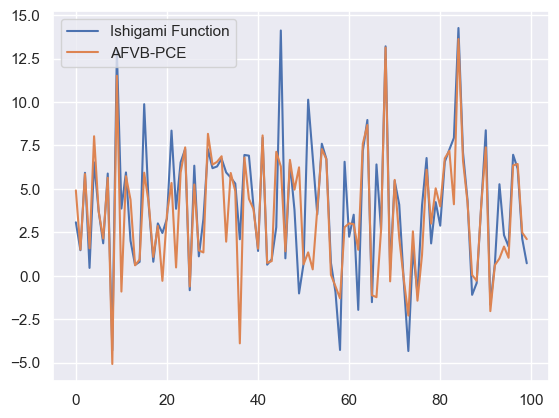

In [22]:
plt.plot(Test_data['Y'], label = "Ishigami Function")
plt.plot(Phi_test@a_hat, label = "AFVB-PCE")
plt.legend();

In [23]:
print("RMSE - Training Data:", mean_squared_error(data['Y'], Phi_full@a_full))
print("RMSE - Training Data:", mean_squared_error(data['Y'], Phi_hat@a_hat))

RMSE - Training Data: 0.032530141573197356
RMSE - Training Data: 0.009639290759016072


In [24]:
a_hat.shape

(13, 1)

In [25]:
print("RMSE - Testing Data:", mean_squared_error(Test_data['Y'], Phi_test_full@a_full))
print("RMSE - Testing Data:", mean_squared_error(Test_data['Y'], Phi_test@a_hat))

RMSE - Testing Data: 4.975264713863819
RMSE - Testing Data: 5.56096646457377


In [14]:
#### The behaviour of this one should be similar to the second problem
#### So the RMSE should reduce when we increase N or p

## PC-VRVM (Tsilifis) - Ishigami Function

In [53]:
################
#### Inputs ####
################
N = 1000 # N --> number of samples
d = 3  # d --> number of random variables
p = 10  # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion

In [54]:
##########################################################################################
#### Generate N samples for d random variables and compute the responses at N samples ####
##########################################################################################
# ---- Setting the example: Coeffs, data and chaos model ------

sys.path.append('..')

np.random.seed(9)

data={'xi':np.random.uniform(-1,1,size=(N,d))}
data['y'] = np.sin(np.pi*data['xi'][:,0]) + 7*(np.sin(np.pi*data['xi'][:,1]))**2 + 0.1*(np.pi*data['xi'][:,2])**4*np.sin(np.pi*data['xi'][:,0])


1.1855627420795019
Iters = 0          Relative error : 14010.248354667236          
5.405150252414921
4.11723331129201
3.2647074818730335
1.0404821187943512
0.9800475334300085
1.7462557385461217
0.2046482439191557
0.0650592810050945
0.17737712009537887
0.800901766747188
Iters = 10          Relative error : 94855195.64694463          
2.5365106084352824
2.435075818479376
2.419371136501095
2.126619272837271
1.8803707238018355
1.8316930953209436
1.8989370630183373
1.938113037283685
1.6518743233371112
1.376917927762399
Iters = 20          Relative error : 10747092.715286165          
1.040953917063817
0.5407242590931816
0.3679559586921002
0.30536234948282015
0.39144952054233073
0.44477077586782343
0.31320081405934985
0.22117444191546554
0.18559632177559138
0.21796634954662863
Iters = 30          Relative error : 2253433.5667237276          
0.34993448982669406
0.5087723114407794
0.42485407353335347
0.1798848252036862
0.05518185227034422
0.01952047614260266
0.009521130242980291
0.0058941053

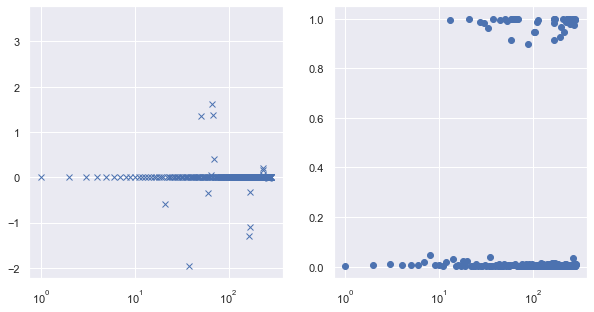

In [55]:
# --- RUN RELEVANCE VECTOR MACHINE FIT
chaos = ChaosModel(d, p, basis, (n,d))

# The success probability for the Bernoulli dinsities is a/(a+b)
# Choices of these parameters allow controling the level of sparsity in the model
a_0 = 0.2
b_0 = 1.0

params = {'omega' : [1e-6, 1e-6], 'tau': [1e-6, 1e-6], 'pi': [ a_0, b_0 ]}

V0 = SparseVariationalOptimizer(chaos, data, params)

c_sol, omega_sol, tau_sol, z_sol, pi_sol, iters, elbo  = V0.optimize(tol = .0001)

df_c = pd.DataFrame(c_sol, columns=['mu','rho'])
df_o = pd.DataFrame(omega_sol, columns=['kappa','lambda'])
df_t = pd.DataFrame(tau_sol, columns=['m','n'])
df_z = pd.DataFrame(z_sol, columns=['pi'])
df_p = pd.DataFrame(pi_sol, columns=['alpha','beta'])
df_elbo = pd.DataFrame(elbo, columns = ['elbo'])

import matplotlib.pyplot as plt 
fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(121)
ax1.plot(c_sol[:,0], 'x')
ax1.set_xscale('log')
ax2 = fig.add_subplot(122)
ax2.plot(z_sol, 'o')
ax2.set_xscale('log')
plt.show()

In [58]:
active_indices = np.array(range(0,n))[z_sol>0.01]

In [59]:
chaos._coeffs = c_sol[:,0]

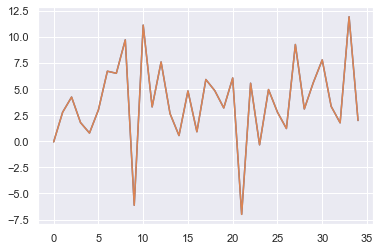

In [60]:
plt.plot(data['y'][0:35])
plt.plot(chaos.eval(data['xi'], active_indices)[0:35]);

### Using Test Data

In [61]:
from sklearn.metrics import mean_squared_error

In [62]:
np.random.seed(99)
Test_data={'xi':np.random.uniform(-1, 1, size=(100,d))}

z_1 = Test_data['xi'][:,0]
z_2 = Test_data['xi'][:,1]
z_3 = Test_data['xi'][:,2]

Test_data['y'] = np.c_[np.sin(np.pi*z_1) + 7*(np.sin(np.pi*z_2))**2 + 0.1*(np.pi*z_3)**4*np.sin(np.pi*z_1)]

In [63]:
print("RMSE - Training Data:", mean_squared_error(data['y'], chaos.eval(data['xi'])))
print("RMSE - Training Data:", mean_squared_error(data['y'], chaos.eval(data['xi'], active_indices)))

RMSE - Training Data: 1.7327292350847173e-05
RMSE - Training Data: 1.912114409535604e-05


In [64]:
print("RMSE - Testing Data:", mean_squared_error(Test_data['y'], chaos.eval(Test_data['xi'])))
print("RMSE - Testing Data:", mean_squared_error(Test_data['y'], chaos.eval(Test_data['xi'], active_indices)))

RMSE - Testing Data: 4.500023609255545e-05
RMSE - Testing Data: 4.5915112394470694e-05
